In [16]:
%load_ext autoreload
%autoreload 2
import sys
# sys.path.append("D:/Github")                                  # for windows
sys.path.append("/Users/xinc./Documents/GitHub/note/module")    # for mac
from glob import glob
from get_info_TWSE import GetInfoTWSE
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.sandwich_covariance import cov_hac
from pprint import pprint

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# get data

In [89]:
list = pd.read_csv("stock_id_list.csv")
list = list["Code"].to_list()

In [ ]:
import urllib3
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

fetcher = GetInfoTWSE()
for id in tqdm(list):
    try:
        df = fetcher.init_df(str(id), "2020-01-01", "2025-09-04")
        df = fetcher.get_stock_price()
        df = fetcher.get_day_trading_info()
        df.to_csv(f"data/{id}.csv", index = True)
    except:
        continue

  2%|▏         | 23/1066 [1:09:12<37:15:10, 128.58s/it]

# Analyse

In [3]:
file = pd.read_csv("data/1108.csv", index_col = "Date")
file["o_c_spread"] = file["Open"] - file["Close"]
file.dropna(inplace = True)

In [18]:
file

,Open,High,Low,Close,Volume,當日沖銷交易成交股數,當日沖銷交易買進成交金額,當日沖銷交易賣出成交金額,當沖佔交易量比例,BiasNorm,o_c_spread,target
Date,,,,,,,,,,,,
2020-01-02,8.38,8.45,8.28,8.37,310216.0,52000,432520,436540,0.167625,-0.004626,0.01,0.03
2020-01-03,8.40,8.40,8.28,8.37,239000.0,22000,183680,183890,0.092050,-0.000571,0.03,0.16
2020-01-06,8.37,8.37,8.21,8.21,191975.0,22000,180900,182790,0.114598,-0.005197,0.16,0.09
2020-01-08,8.24,8.28,8.15,8.15,94000.0,9000,73560,73620,0.095745,-0.000408,0.09,-0.03
2020-01-09,8.15,8.22,8.15,8.18,120076.0,3000,24450,24660,0.024984,-0.004276,-0.03,0.11
...,...,...,...,...,...,...,...,...,...,...,...,...
2025-08-28,15.25,15.35,15.25,15.25,137908.0,1000,15300,15250,0.007251,0.001637,0.00,-0.05
2025-08-29,15.30,15.45,15.30,15.35,337529.0,6000,92350,92150,0.017776,0.001084,-0.05,0.05
2025-09-01,15.40,15.40,15.25,15.35,333990.0,3000,45950,46050,0.008982,-0.001087,0.05,0.05


### 看資料傾向

In [25]:
"""concat 成 panel data"""

files = glob("test_data/*.csv")
dfs = []
for f in files:
    stock_id = f.split("\\")[-1].replace(".csv","")
    df = pd.read_csv(f, parse_dates = ["Date"])
    df["stock"] = stock_id
    df["c_o_spread"] = df["Close"] - df["Open"]         # 建立 Close - Open
    df["c_o_spread_t+1"] = df["c_o_spread"].shift(-1)
    dfs.append(df)

df_all = pd.concat(dfs, ignore_index = True)
df_all = df_all.sort_values(["Date","stock"])
df_all.dropna(inplace = True)

# 把 'stock' 移到第二個位置
cols = df_all.columns.tolist()
cols.remove("stock")
cols.insert(1, "stock")
df_all = df_all[cols]

In [42]:
"""畫圖 function"""

def sorted_cumY_plot(df_all: pd.DataFrame, x: str, y: str):
    # 排序 (由小到大)
    df_all_sorted = df_all.sort_values(x).reset_index(drop = True)

    # 累加 target
    df_all_sorted[f"cumulative_{y}"] = df_all_sorted[y].cumsum()

    # 畫圖
    plt.figure(figsize = (16, 5))
    plt.plot(df_all_sorted[x], df_all_sorted[f"cumulative_{y}"], label = f"cum {y}")
    plt.xlabel("date trading ratio")
    plt.ylabel("cum target")
    plt.legend()
    plt.grid(True)
    plt.show()

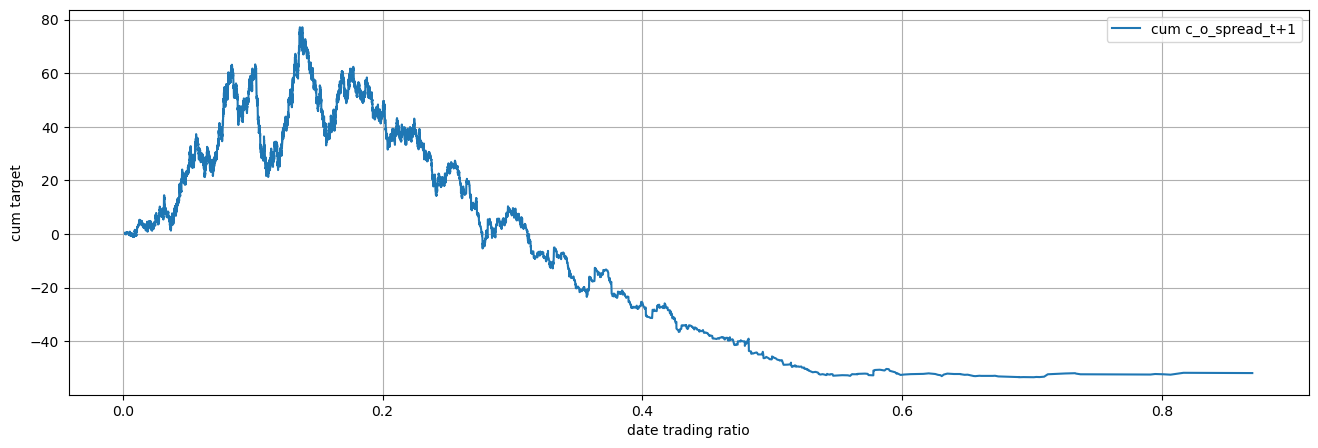

In [43]:
sorted_cumY_plot(df_all, "當沖佔交易量比例", "c_o_spread_t+1")

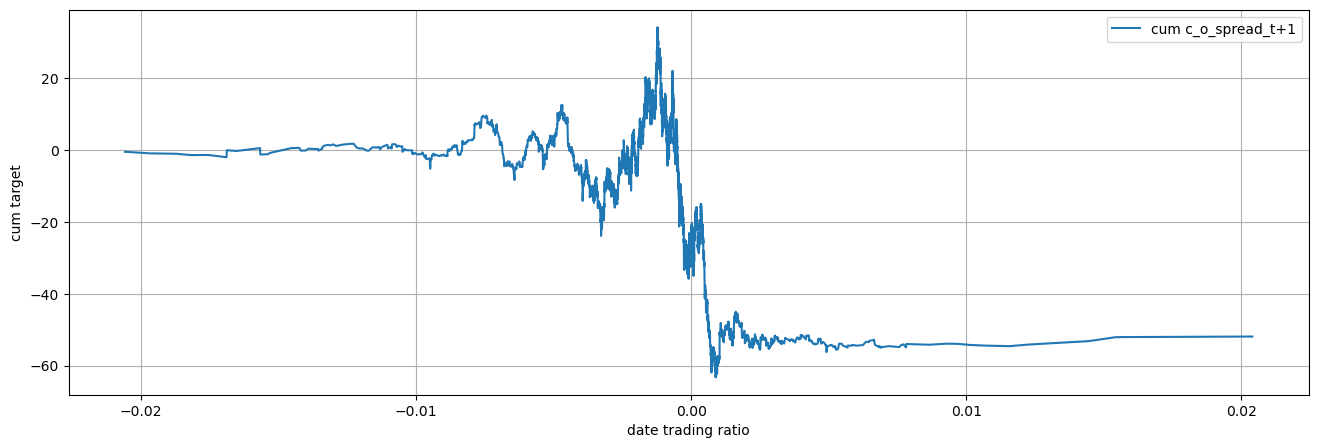

In [44]:
sorted_cumY_plot(df_all, "BiasNorm", "c_o_spread_t+1")

## regression

### macro

In [ ]:
"""concat 成 panel data"""

files = glob("test_data/*.csv")
dfs = []
for f in files:
    stock_id = f.split("\\")[-1].replace(".csv","")
    df = pd.read_csv(f, parse_dates = ["Date"])
    df["stock"] = stock_id
    df["c_o_spread"] = df["Close"] - df["Open"]         # 建立 Close - Open
    df["c_o_spread_t+1"] = df["c_o_spread"].shift(-1)
    dfs.append(df)

df_all = pd.concat(dfs, ignore_index = True)
df_all = df_all.sort_values(["Date","stock"])
df_all.dropna(inplace = True)

# 把 'stock' 移到第二個位置
cols = df_all.columns.tolist()
cols.remove("stock")
cols.insert(1, "stock")
df_all = df_all[cols]

In [116]:
"""fama macbeth regression"""

# cross sectional regression
rows = []
dates = []

vars_ = ["當沖佔交易量比例", "BiasNorm"]

for dt, g in df_all.groupby("Date"):
    Y = g["c_o_spread_t+1"]
    X = g[vars_]
    X = sm.add_constant(X)

    # 確保樣本不會太少
    if len(g) > X.shape[1] + 3:
        res = sm.OLS(Y, X).fit()
        rows.append(res.params.reindex(vars_).astype(float))
        dates.append(dt)

betas_df = pd.DataFrame(rows, index=pd.Index(dates, name="Date")).sort_index()

# time series average
out = []
T = betas_df.shape[0]
X_time = sm.add_constant(np.ones(T))

# statistic
for col in betas_df.columns:
    series_t = betas_df[col].dropna()
    # 平均β
    beta_bar = series_t.mean()
    # NW-SE
    res_time = sm.OLS(series_t.values, X_time[:len(series_t)]).fit()
    cov = cov_hac(res_time)
    se_nw = np.sqrt(cov[0, 0])
    t_nw = beta_bar / se_nw
    out.append((col, beta_bar, se_nw, t_nw, len(series_t)))

res_table = pd.DataFrame(out, columns = ["var","beta_bar","SE_NW","t_NW","T"])
res_table

,var,beta_bar,SE_NW,t_NW,T
0,當沖佔交易量比例,-0.073933,0.049480,-1.494196,1379
1,BiasNorm,-6.838958,2.686327,-2.545839,1379


In [ ]:
X = file[["當沖佔交易量比例", "BiasNorm", "當日沖銷交易賣出成交金額"]]
X = sm.add_constant(X)
y = file["o_c_spread"].values

reg = sm.OLS(y, X, missing = "drop").fit()

# VIF
vif = pd.DataFrame()
vif["variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

In [9]:
vif

,variable,VIF
0,const,2.882881
1,當沖佔交易量比例,1.264467
2,BiasNorm,1.015175
3,當日沖銷交易賣出成交金額,1.265735


In [10]:
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.137
Model:                            OLS   Adj. R-squared:                  0.135
Method:                 Least Squares   F-statistic:                     70.93
Date:                Sat, 06 Sep 2025   Prob (F-statistic):           1.40e-42
Time:                        19:59:25   Log-Likelihood:                 236.94
No. Observations:                1347   AIC:                            -465.9
Df Residuals:                    1343   BIC:                            -445.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0542      0.009      5.761   

### industry

In [53]:
import requests
import pandas as pd

stock = "2330"  # 台積電
url = f"https://openapi.twse.com.tw/v1/exchangeReport/BWIBBU_d?stockNo={stock}"
data = requests.get(url, timeout=30, verify = False).json()

df = pd.DataFrame(data)
df["市值(元)"] = pd.to_numeric(df["市值(百萬元)"], errors="coerce") * 1_000_000

print(df[["日期", "證券代號", "證券名稱", "市值(元)"]])


c:\Users\ownme\anaconda3\envs\quant\Lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openapi.twse.com.tw'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


KeyError: '市值(百萬元)'

## random forest

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, confusion_matrix, classification_report
from sklearn.metrics import mean_squared_error, r2_score

### naive random forest

In [16]:
"""預測方向"""

file["target"] = file["o_c_spread"].shift(-1)

data = file.dropna()

X = data[["當日沖銷交易賣出成交金額", "當沖佔交易量比例", "BiasNorm"]]
y = (data["target"] > 0).astype(int)

# 切資料
split_point = int(len(X) * 0.8)
X_train, X_test = X.iloc[: split_point], X.iloc[split_point: ]
y_train, y_test = y.iloc[: split_point], y.iloc[split_point: ]

rf = RandomForestClassifier(
    n_estimators = 300,     # 樹的數量
    max_depth = None,       # 不限制深度
    class_weight = "balanced_subsample",
    n_jobs = -1
)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:,1]

# metrics
acc = accuracy_score(y_test, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred, average = "binary", zero_division = 0)
auc = roc_auc_score(y_test, y_proba)
cm = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {acc:.3f} | Precision: {prec:.3f} | Recall: {rec:.3f} | F1: {f1:.3f} | ROC-AUC: {auc:.3f}")
print("Confusion matrix:\n", cm)

# feature 重要性
imp = pd.DataFrame({"Feature": X.columns, "Importance": rf.feature_importances_})\
        .sort_values("Importance", ascending=False)

imp

Accuracy: 0.578 | Precision: 0.546 | Recall: 0.476 | F1: 0.509 | ROC-AUC: 0.561
Confusion matrix:
 [[97 49]
 [65 59]]


,Feature,Importance
2,BiasNorm,0.336074
0,當日沖銷交易賣出成交金額,0.335098
1,當沖佔交易量比例,0.328828


### target encoding random forest

In [17]:
def target_encode_timeseries(train: pd.DataFrame, valid: pd.DataFrame, col: str, target: str) -> pd.Series:
    """
    train: 訓練集 (只用過去資料)
    valid: 驗證集 (未來資料)
    col:   要做 target encoding 的欄位 (例如 'Industry')
    target: 標籤欄位 (例如 'target')
    """
    # get mean of train data
    mapping = train.groupby(col)[target].mean()

    # encode valid data by mean of train
    valid_encoded = valid[col].map(mapping)

    return valid_encoded

In [21]:
tscv = TimeSeriesSplit(n_splits = 5)
X = data[["Industry", "當沖佔交易量比例"]].copy()

KeyError: "['Industry'] not in index"